In [1]:
import os
import logging
import glob
import pandas as pd

import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from zoobot import label_metadata, schemas
from zoobot.data_utils import image_datasets
from zoobot.estimators import define_model, preprocess
from zoobot.predictions import predict_on_tfrecords, predict_on_images
from zoobot.stats import vote_stats

import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

2021-09-02 10:12:48.148757: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
model_to_predict = 'model_dense'

In [3]:
decals_test = pd.read_csv('../Ilifu_data/decals_ilifu_test.csv')

In [4]:
test_paths = decals_test['file_loc'].to_numpy()

In [5]:
file_format = 'png'
initial_size = 300
batch_size = 64
raw_image_ds = image_datasets.get_image_dataset([str(x) for x in test_paths], file_format, initial_size, batch_size)

preprocessing_config = preprocess.PreprocessingConfig(
    label_cols=[],
    input_size=initial_size,
    make_greyscale=True,
    normalise_from_uint8=False
)

image_ds = preprocess.preprocess_dataset(raw_image_ds, preprocessing_config)

INFO:root:Images to predict on: 49917
2021-09-02 10:15:13.990635: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-02 10:15:14.009306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-02 10:15:14.010213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:08.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2021-09-02 10:15:14.010258: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-02 10:15:14.726343: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-02 10:15:14.726

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


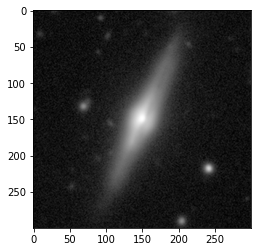

In [6]:
for element in image_ds:
    for image in element[0]:
        img = np.array(image)
    break

plt.imshow(img, cmap='gray')
plt.show()

In [7]:
model = define_model.load_model(
    checkpoint_loc="../trained_models/{}/checkpoint".format(model_to_predict),
    include_top=True,
    input_size=300,
    crop_size=224,
    resize_size=224,
    expect_partial=True  # optimiser state will not load as we're not using it for predictions
)

print(model.summary())
label_cols = label_metadata.decals_label_cols

INFO:root:Input size 300, crop size 224, final size 224


INFO:root:Loading weights from ../trained_models/model_dense/checkpoint


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_rotation (RandomRotat (None, 300, 300, 1)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 300, 300, 1)       0         
_________________________________________________________________
random_crop (RandomCrop)     (None, 224, 224, 1)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7031232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 34)                34850     
Total params: 7,066,083
Trainable params: 6,982,434
Non-trainable params: 83,649
_________________________________________

In [11]:
test = np.array([img])
model.predict(test)

2021-09-02 10:16:12.409773: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-09-02 10:16:18.596107: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2021-09-02 10:16:29.347508: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-02 10:16:38.188533: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


array([[12.066832 , 91.61514  ,  4.2379456, 79.44149  ,  1.4142308,
         3.1135695, 16.957653 ,  3.1655474,  2.8952718,  7.6127577,
         2.8372815,  9.688677 , 48.10134  , 12.531884 ,  2.2208357,
         1.035808 ,  2.9926496, 51.86832  ,  4.8089714,  1.4481214,
        45.98712  , 19.11196  ,  7.931461 ,  3.3752446,  1.520551 ,
         4.3415403,  1.2818522,  1.2976371,  2.8596668, 24.283657 ,
        42.149963 ,  9.056942 ,  1.4619211,  1.8679287]], dtype=float32)

In [12]:
save_loc = '../predictions/gzd5_{}_predictions.csv'.format(model_to_predict)
n_samples = 5
predict_on_images.predict(image_ds, model, n_samples, label_cols, save_loc)

INFO:root:Beginning predictions
INFO:root:Starting at: 2021-09-02 10:21:09
INFO:root:Predictions complete - (49917, 34, 5)
INFO:root:Predictions saved to ../predictions/gzd5_model_dense_predictions.csv
INFO:root:Completed at: 2021-09-02 10:28:07
INFO:root:Time elapsed: 0:06:57.867752
